Install neccicary packages

In [ ]:
!pip install seaborn numpy pandas matplotlib

Imports

In [1]:
# Import common data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
# Calculate p-values for correlations
from scipy import stats
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Import additional required libraries
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# 1. Load the Data

In [3]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [6]:
# Read the dataset
df = pd.read_csv('/content/lung_cancer_data.csv')

# Display first few rows and basic information about the dataset
print("First 5 rows of the dataset:")
print(df.head())

print("\nDataset info:")
print(df.info())

First 5 rows of the dataset:
    Patient_ID  Age  Gender Smoking_History  Tumor_Size_mm Tumor_Location  \
0  Patient0000   68    Male  Current Smoker      81.678677     Lower Lobe   
1  Patient0001   58    Male    Never Smoked      78.448272     Lower Lobe   
2  Patient0002   44    Male   Former Smoker      67.714305     Lower Lobe   
3  Patient0003   72    Male  Current Smoker      70.806008     Lower Lobe   
4  Patient0004   37  Female    Never Smoked      87.272433     Lower Lobe   

       Stage          Treatment  Survival_Months         Ethnicity  ...  \
0  Stage III            Surgery               44          Hispanic  ...   
1    Stage I  Radiation Therapy              101         Caucasian  ...   
2    Stage I       Chemotherapy               69  African American  ...   
3  Stage III       Chemotherapy               95  African American  ...   
4   Stage IV  Radiation Therapy              105             Asian  ...   

  Alanine_Aminotransferase_Level Aspartate_Aminotransfera

The origional challenge was to predict weather a patient will survive. It is my understanding that 5 year survival rate is the precident for determining "survival"



In [7]:
# Create new column for 5-year survival
# 5 years = 60 months
df['Survived_5_Years'] = df['Survival_Months'].apply(lambda x: 'Yes' if x >= 60 else 'No')

# Let's see the distribution
print("Distribution of 5-year survival:")
print(df['Survived_5_Years'].value_counts())
print("\nPercentage distribution:")
print(df['Survived_5_Years'].value_counts(normalize=True) * 100)

Distribution of 5-year survival:
Survived_5_Years
Yes    6228
No     6098
Name: count, dtype: int64

Percentage distribution:
Survived_5_Years
Yes    50.527341
No     49.472659
Name: proportion, dtype: float64


Im sure that stage of cancer is the largest factor in determining how many patients survive 5 years

5-year survival rates by stage:
Survived_5_Years         No        Yes
Stage                                 
Stage I           49.544567  50.455433
Stage II          49.484879  50.515121
Stage III         49.870968  50.129032
Stage IV          48.997773  51.002227


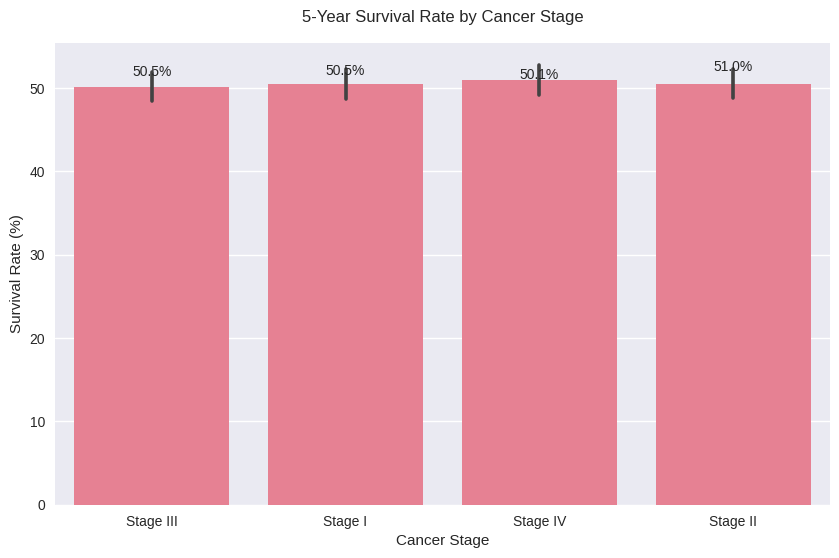

In [8]:
# Calculate survival rates by stage
survival_by_stage = pd.crosstab(df['Stage'], df['Survived_5_Years'], normalize='index') * 100

# Print the percentages
print("5-year survival rates by stage:")
print(survival_by_stage)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Stage', y=100*(df['Survived_5_Years'] == 'Yes').astype(int))

# Customize the plot
plt.title('5-Year Survival Rate by Cancer Stage', pad=15)
plt.xlabel('Cancer Stage')
plt.ylabel('Survival Rate (%)')

# Add percentage labels on top of each bar
survival_percentages = survival_by_stage['Yes']
for i, v in enumerate(survival_percentages):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.show()

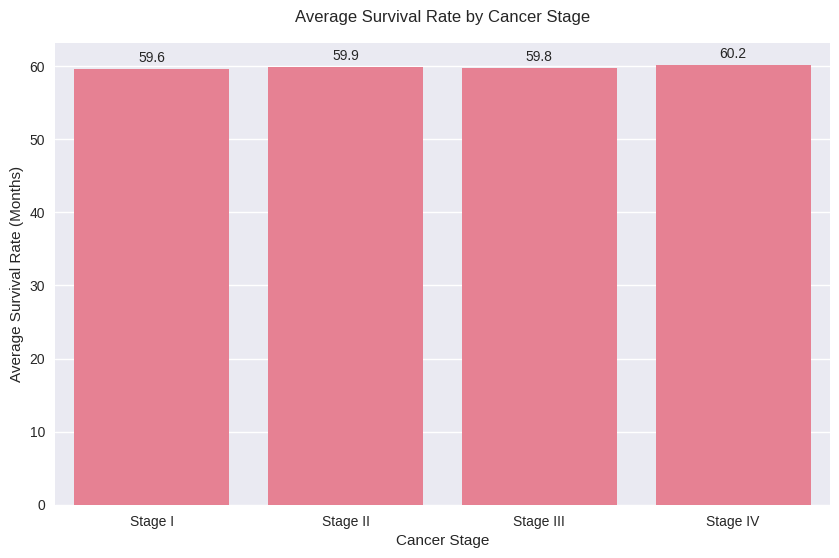

In [21]:



# Calculate average survival rate by stage
avg_survival_by_stage = df.groupby('Stage')['Survival_Months'].mean()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_survival_by_stage.index, y=avg_survival_by_stage.values)

# Customize the plot
plt.title('Average Survival Rate by Cancer Stage', pad=15)
plt.xlabel('Cancer Stage')
plt.ylabel('Average Survival Rate (Months)')

# Add value labels on top of each bar
for i, v in enumerate(avg_survival_by_stage.values):
    plt.text(i, v + 1, f'{v:.1f}', ha='center')

plt.show()

Now im going to see ifthere is any relation with tumor size

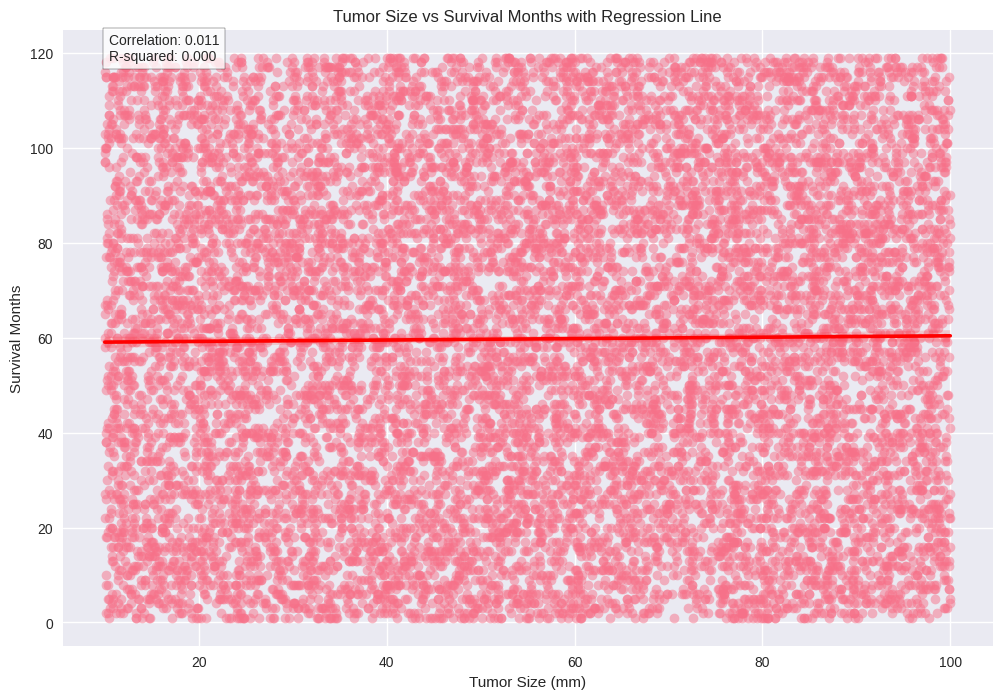

In [9]:
# Create the scatter plot with regression line
plt.figure(figsize=(12, 8))

# Plot scatter points
sns.regplot(data=df, x='Tumor_Size_mm', y='Survival_Months', scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})

# Customize the plot
plt.title('Tumor Size vs Survival Months with Regression Line')
plt.xlabel('Tumor Size (mm)')
plt.ylabel('Survival Months')

# Calculate correlation coefficient and R-squared
correlation = df['Tumor_Size_mm'].corr(df['Survival_Months'])
from sklearn.linear_model import LinearRegression

# Prepare data for regression
X = df['Tumor_Size_mm'].values.reshape(-1, 1)
y = df['Survival_Months'].values

# Fit regression
reg = LinearRegression().fit(X, y)
r_squared = reg.score(X, y)

# Add text box with statistics
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}\nR-squared: {r_squared:.3f}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

This is not predictive at all, I suspect that wheather a tumor can metastasize will have a large impact, as the spread of a cancer depends on both the amount of cells and weather these cells can metastesize. Im going to make different plots for each stage as that should work as an accurate predictor of metastasis potential

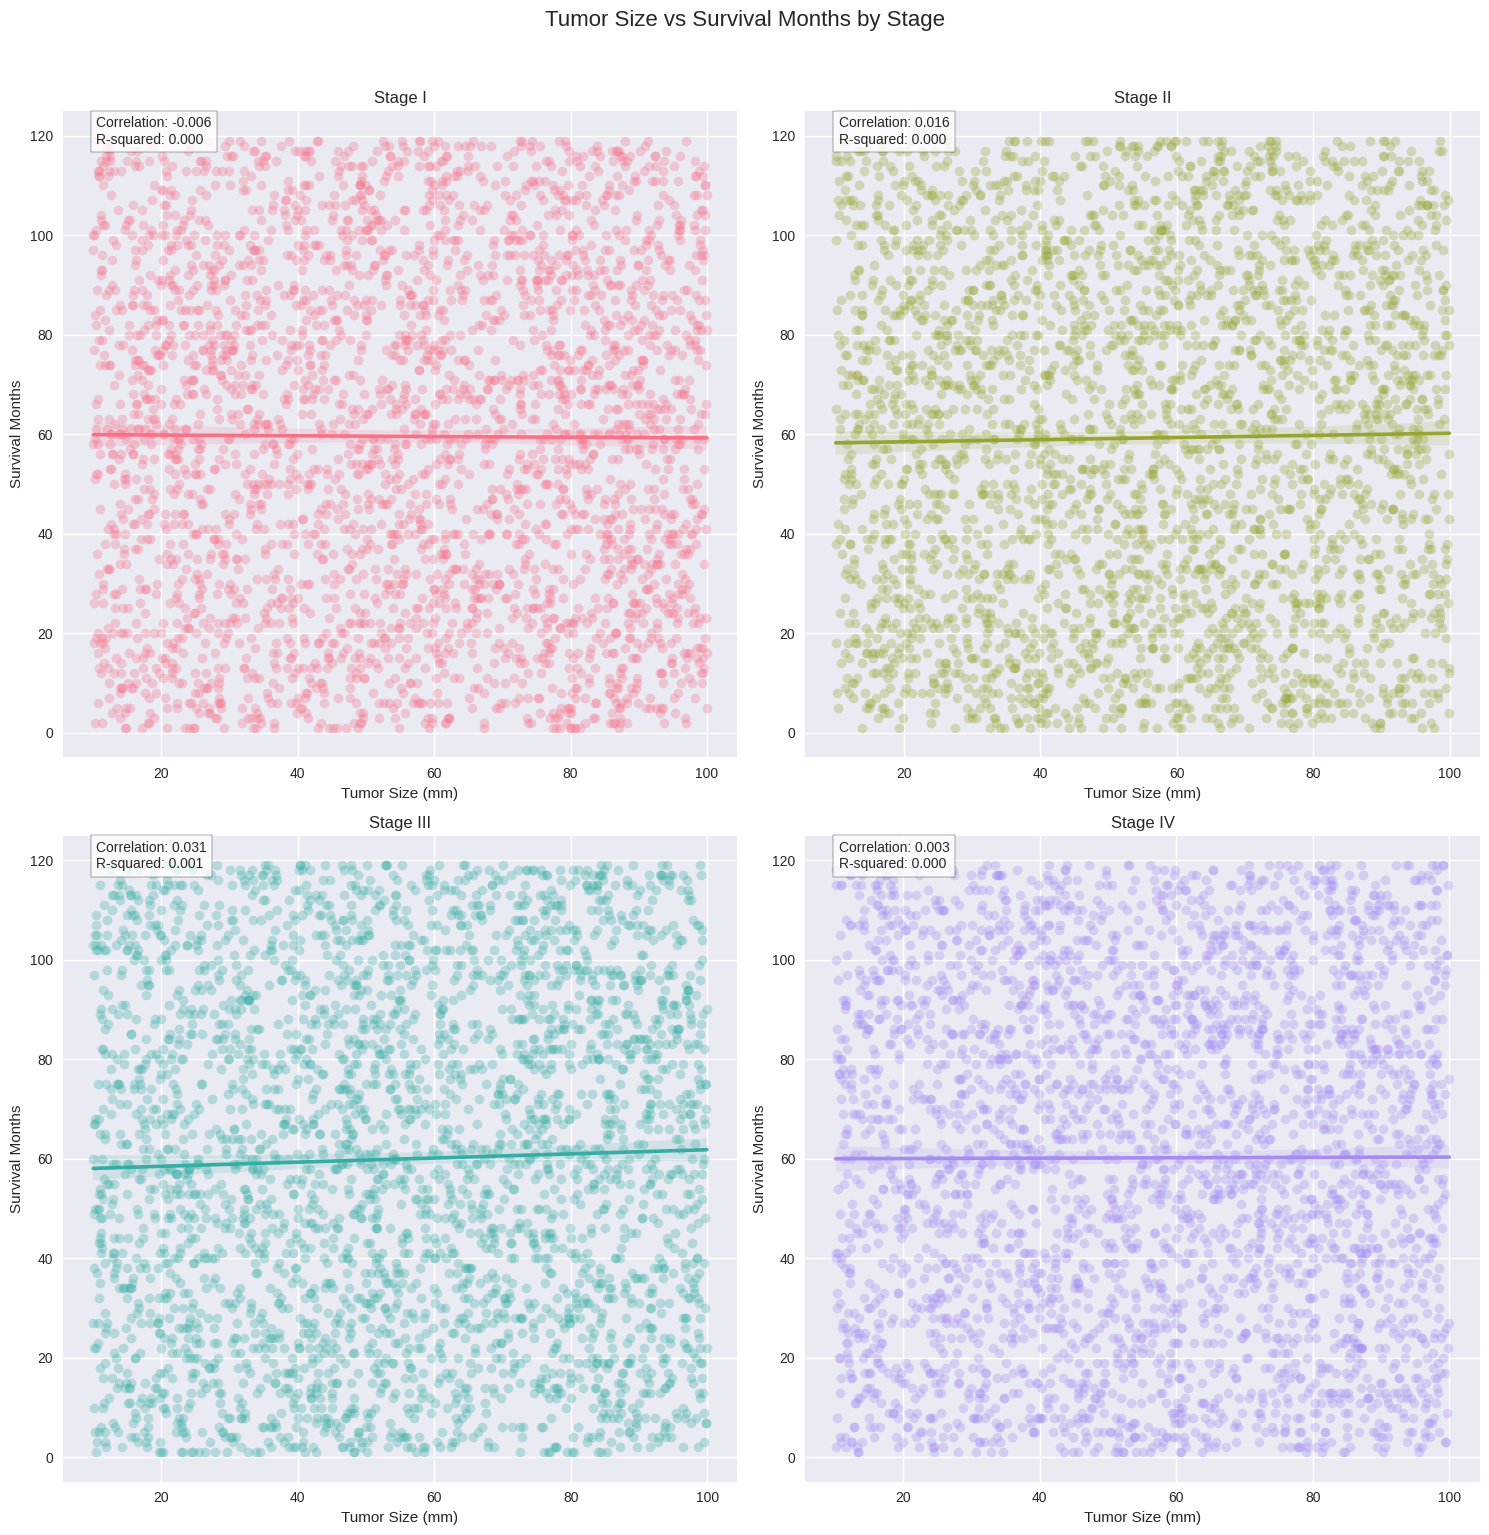

In [10]:
# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('Tumor Size vs Survival Months by Stage', fontsize=16, y=1.02)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Create unique color for each stage
stages = sorted(df['Stage'].unique())  # Sort stages to ensure correct order
colors = sns.color_palette("husl", len(stages))

# Create a plot for each stage
for idx, (stage, color) in enumerate(zip(stages, colors)):
    # Get data for this stage
    stage_data = df[df['Stage'] == stage]

    # Create regression plot
    sns.regplot(data=stage_data,
                x='Tumor_Size_mm',
                y='Survival_Months',
                scatter_kws={'alpha':0.3},
                line_kws={'color': color},
                color=color,
                ax=axes[idx])

    # Calculate statistics
    correlation = stage_data['Tumor_Size_mm'].corr(stage_data['Survival_Months'])
    X = stage_data['Tumor_Size_mm'].values.reshape(-1, 1)
    y = stage_data['Survival_Months'].values
    reg = LinearRegression().fit(X, y)
    r_squared = reg.score(X, y)

    # Set title and add statistics
    axes[idx].set_title(f'{stage}')
    axes[idx].text(0.05, 0.95,
                  f'Correlation: {correlation:.3f}\nR-squared: {r_squared:.3f}',
                  transform=axes[idx].transAxes,
                  bbox=dict(facecolor='white', alpha=0.8))

    # Set labels
    axes[idx].set_xlabel('Tumor Size (mm)')
    axes[idx].set_ylabel('Survival Months')

plt.tight_layout()
plt.show()

I notice alot of categorical variables, and some must impact prognosis more than others, so I will probably end up using a random forest/decision tree


Im going to check if there are any correlations for us to engineer a ML model based on those

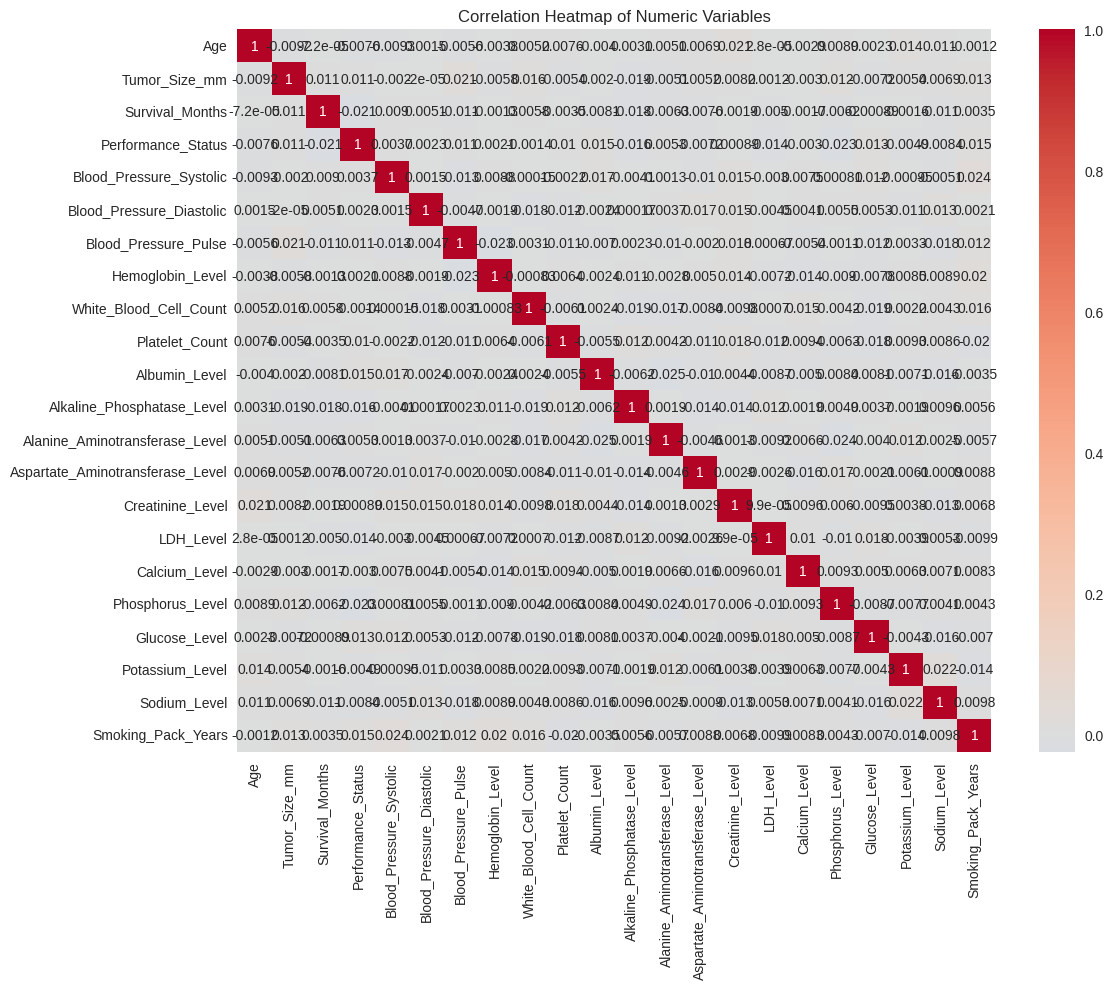


Strongest correlations (absolute value > 0.3):


In [11]:
# Calculate correlation matrix for numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_cols].corr()

# Create heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numeric Variables')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print strongest correlations
print("\nStrongest correlations (absolute value > 0.3):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j]) > 0.3:
            print(f"{correlation_matrix.columns[i]} & {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i,j]:.3f}")

Lets see what correlations exist

I didnt find any correlations, so lets just run some statistics on the dataset to see if there can be any indicators

BASIC DATASET STATISTICS:
Total patients: 12326

Survival Statistics:
count    12326.000000
mean        59.744848
std         34.338792
min          1.000000
25%         30.000000
50%         60.000000
75%         89.000000
max        119.000000
Name: Survival_Months, dtype: float64

SURVIVAL BY STAGE:
            count       mean        std  min   25%   50%   75%    max
Stage                                                                
Stage I    3074.0  59.581978  34.053784  1.0  30.0  60.0  88.0  119.0
Stage II   3009.0  59.241609  34.389447  1.0  28.0  60.0  88.0  119.0
Stage III  3100.0  59.951290  34.543544  1.0  30.0  60.0  89.0  119.0
Stage IV   3143.0  60.182310  34.374369  1.0  30.0  61.0  89.0  119.0

TREATMENT OUTCOMES:
Treatment
Radiation Therapy    60.226179
Surgery              59.834845
Chemotherapy         59.732371
Targeted Therapy     59.154236
Name: Survival_Months, dtype: float64

AGE ANALYSIS:
            count       mean        std   min   25%   50%   75%   ma

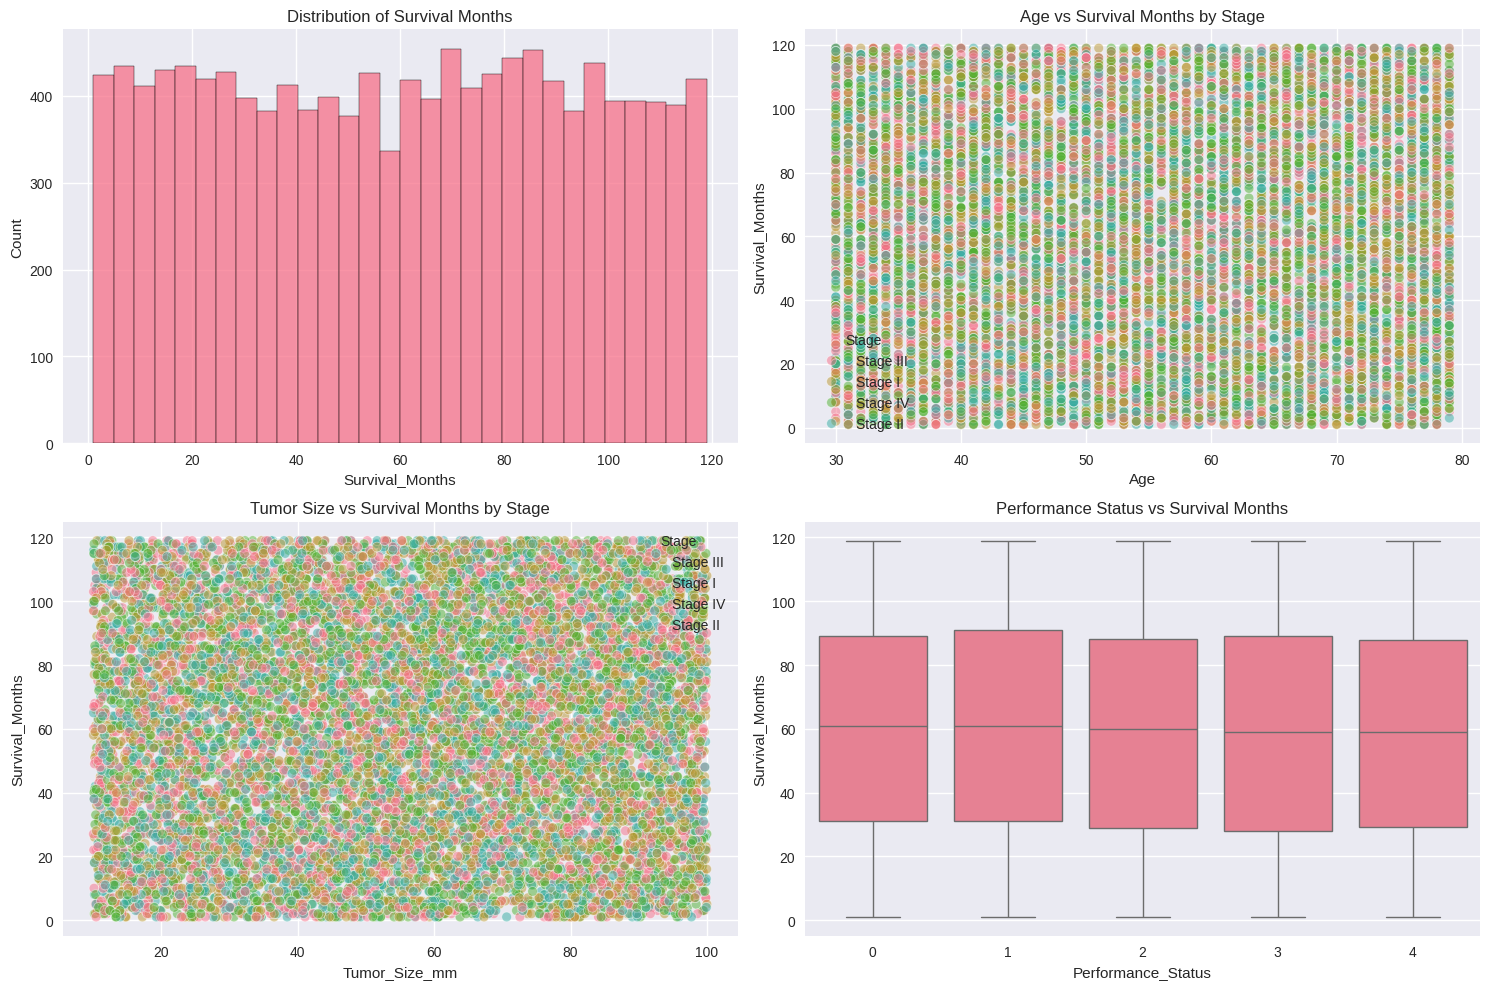

In [14]:

# 1. Basic Statistics
print("BASIC DATASET STATISTICS:")
print(f"Total patients: {len(df)}")
print("\nSurvival Statistics:")
print(df['Survival_Months'].describe())

# 2. Stage Distribution and Survival
print("\nSURVIVAL BY STAGE:")
stage_survival = df.groupby('Stage')['Survival_Months'].describe()
print(stage_survival)

# 3. Treatment Outcomes
print("\nTREATMENT OUTCOMES:")
treatment_survival = df.groupby('Treatment')['Survival_Months'].mean().sort_values(ascending=False)
print(treatment_survival)

# 4. Age Analysis
print("\nAGE ANALYSIS:")
print(df.groupby('Stage')['Age'].describe())

# 5. Risk Factors Analysis
print("\nSMOKING HISTORY IMPACT:")
smoking_impact = df.groupby('Smoking_History')['Survival_Months'].describe()
print(smoking_impact)

# 6. Correlation Analysis for Key Variables
key_vars = ['Age', 'Tumor_Size_mm', 'Survival_Months', 'Performance_Status',
            'Hemoglobin_Level', 'White_Blood_Cell_Count', 'LDH_Level']
correlation = df[key_vars].corr()
print("\nKEY CORRELATIONS:")
print(correlation['Survival_Months'].sort_values(ascending=False))

# 7. Create survival classifier
df['Long_Term_Survival'] = df['Survival_Months'] >= df['Survival_Months'].median()
X = df[key_vars]
y = df['Long_Term_Survival']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print("\nSURVIVAL PREDICTION MODEL:")
print("\nFeature Importances:")
for feat, imp in zip(key_vars, rf.feature_importances_):
    print(f"{feat}: {imp:.3f}")

# 8. Comorbidity Analysis
comorbidity_cols = [col for col in df.columns if 'Comorbidity' in col]
comorbidity_impact = df.groupby(comorbidity_cols[0])['Survival_Months'].mean()
print("\nCOMORBIDITY IMPACT ON SURVIVAL:")
print(comorbidity_impact)

# Visualizations
plt.figure(figsize=(15, 10))

# 1. Survival Distribution
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='Survival_Months', bins=30)
plt.title('Distribution of Survival Months')

# 2. Age vs Survival
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='Age', y='Survival_Months', hue='Stage', alpha=0.5)
plt.title('Age vs Survival Months by Stage')

# 3. Tumor Size vs Survival
plt.subplot(2, 2, 3)
sns.scatterplot(data=df, x='Tumor_Size_mm', y='Survival_Months', hue='Stage', alpha=0.5)
plt.title('Tumor Size vs Survival Months by Stage')

# 4. Performance Status vs Survival
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='Performance_Status', y='Survival_Months')
plt.title('Performance Status vs Survival Months')

plt.tight_layout()
plt.show()



Having seen this data, I think the best classifyer will be a decision tree, this is because we can se the effect of each factor on overall prognosis

Data Shape: (23658, 38)
    Patient_ID  Age  Gender Smoking_History  Tumor_Size_mm Tumor_Location  \
0  Patient0000   68    Male  Current Smoker      81.678677     Lower Lobe   
1  Patient0001   58    Male    Never Smoked      78.448272     Lower Lobe   
2  Patient0002   44    Male   Former Smoker      67.714305     Lower Lobe   
3  Patient0003   72    Male  Current Smoker      70.806008     Lower Lobe   
4  Patient0004   37  Female    Never Smoked      87.272433     Lower Lobe   

       Stage          Treatment  Survival_Months         Ethnicity  ...  \
0  Stage III            Surgery               44          Hispanic  ...   
1    Stage I  Radiation Therapy              101         Caucasian  ...   
2    Stage I       Chemotherapy               69  African American  ...   
3  Stage III       Chemotherapy               95  African American  ...   
4   Stage IV  Radiation Therapy              105             Asian  ...   

  Alanine_Aminotransferase_Level Aspartate_Aminotransferase_Le

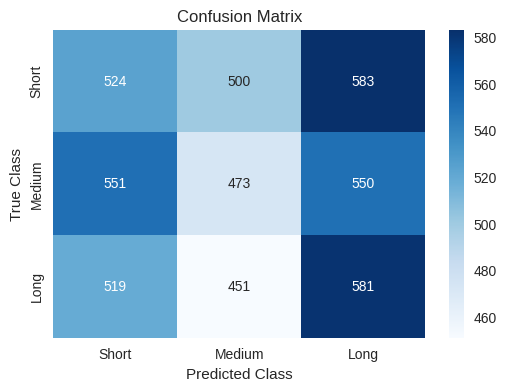

In [15]:

df = pd.read_csv("lung_cancer_data.csv")
print("Data Shape:", df.shape)
print(df.head())

# 2. Create a Categorical Target by Binning Survival_Months
# Using quantiles ensures roughly balanced classes.
df['Survival_Class'] = pd.qcut(df['Survival_Months'], q=3, labels=['Short', 'Medium', 'Long'])
print("Value Counts of Survival Classes:")
print(df['Survival_Class'].value_counts())

# Remove columns that are not needed for modeling (e.g., identifiers and the original survival months)
df = df.drop(columns=['Patient_ID', 'Survival_Months'])

# 3. Preprocess the Data

# Identify the columns
# For demonstration, we assume the following columns are categorical:
categorical_cols = [
    'Gender', 'Smoking_History', 'Tumor_Location', 'Stage', 'Treatment',
    'Ethnicity', 'Insurance_Type', 'Family_History',
    'Comorbidity_Diabetes', 'Comorbidity_Hypertension', 'Comorbidity_Heart_Disease',
    'Comorbidity_Chronic_Lung_Disease', 'Comorbidity_Kidney_Disease',
    'Comorbidity_Autoimmune_Disease', 'Comorbidity_Other'
]

# All remaining columns (besides the target) are considered numeric.
all_cols = df.columns.tolist()
target = 'Survival_Class'
numeric_cols = [col for col in all_cols if col not in categorical_cols + [target]]

print("Numeric Features:", numeric_cols)
print("Categorical Features:", categorical_cols)

# Build a preprocessor that scales numeric features and one-hot encodes categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# 4. Create a Pipeline with a Random Forest Classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# 5. Evaluate the Model

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Compute accuracy and print a classification report
accuracy = accuracy_score(y_test, y_pred)
print("\nAccuracy on Test Set:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Short', 'Medium', 'Long'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=['Short', 'Medium', 'Long'],
            yticklabels=['Short', 'Medium', 'Long'])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


Lets try some decision trees, with different depths, to see if we can improve models accuracies. I suspect that survival rates depend on a combination/interplay of factors, so a decision tree makes sense in this context.

Depth 2: Train Acc = 0.509, Test Acc = 0.504
Depth 3: Train Acc = 0.511, Test Acc = 0.505
Depth 4: Train Acc = 0.514, Test Acc = 0.499
Depth 5: Train Acc = 0.520, Test Acc = 0.496
Depth 6: Train Acc = 0.526, Test Acc = 0.504
Depth 7: Train Acc = 0.534, Test Acc = 0.510
Depth 8: Train Acc = 0.538, Test Acc = 0.511
Depth 9: Train Acc = 0.540, Test Acc = 0.512
Depth 10: Train Acc = 0.541, Test Acc = 0.512
Depth 15: Train Acc = 0.542, Test Acc = 0.511
Depth 20: Train Acc = 0.542, Test Acc = 0.511
Depth 25: Train Acc = 0.542, Test Acc = 0.511
Depth 30: Train Acc = 0.542, Test Acc = 0.511
Depth 35: Train Acc = 0.542, Test Acc = 0.511
Depth 40: Train Acc = 0.542, Test Acc = 0.511
Depth 45: Train Acc = 0.542, Test Acc = 0.511
Depth 50: Train Acc = 0.542, Test Acc = 0.511


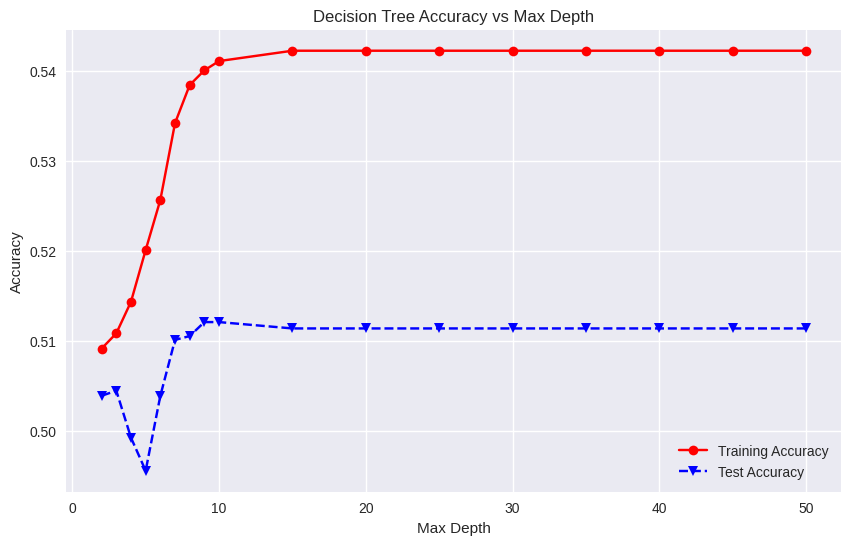


Best max_depth: 9
Best test accuracy: 0.512

Final Model Performance:
Accuracy: 51.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.50      0.50      3524
           1       0.52      0.52      0.52      3574

    accuracy                           0.51      7098
   macro avg       0.51      0.51      0.51      7098
weighted avg       0.51      0.51      0.51      7098



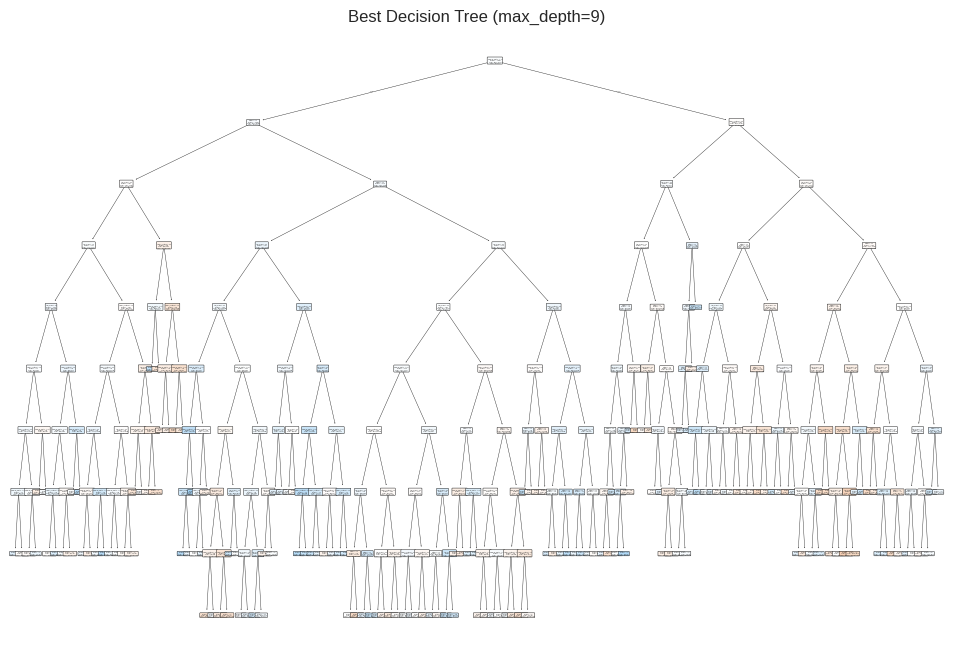

In [16]:

# Read the data
data = pd.read_csv('lung_cancer_data.csv')

# Age Classification
bins = [30, 40, 50, 60, 70, 80]
labels = ['30s', '40s', '50s', '60s', '70s']
data['Age_Class'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Convert to numeric with LabelEncoder
le_age_class = LabelEncoder()
data['Age_Class'] = le_age_class.fit_transform(data['Age_Class'])
data['Age_Class'] = data['Age_Class'].astype(int)

# Encode categorical variables
le_smoking = LabelEncoder()
le_tumor = LabelEncoder()
le_stage = LabelEncoder()

data['Smoking_History'] = le_smoking.fit_transform(data['Smoking_History'])
data['Tumor_Location'] = le_tumor.fit_transform(data['Tumor_Location'])
data['Stage'] = le_stage.fit_transform(data['Stage'])

#Create binary survival target (>=60 months = 1)
survival_threshold = 60
data['Survival'] = (data['Survival_Months'] >= survival_threshold).astype(int)

#  Select features and target
X = data[['Smoking_History', 'Tumor_Location', 'Stage', 'Age_Class']]
y = data['Survival']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Test different max depths
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]
trainAcc = np.zeros(len(maxdepths))
testAcc = np.zeros(len(maxdepths))

# For each depth, train a model and record accuracies
for idx, depth in enumerate(maxdepths):
    clf = DecisionTreeClassifier(max_depth=depth)
    clf.fit(X_train, y_train)

    # Get predictions and calculate accuracies
    trainAcc[idx] = accuracy_score(y_train, clf.predict(X_train))
    testAcc[idx] = accuracy_score(y_test, clf.predict(X_test))
    print(f"Depth {depth}: Train Acc = {trainAcc[idx]:.3f}, Test Acc = {testAcc[idx]:.3f}")

# Plot the accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(maxdepths, trainAcc, 'ro-', label='Training Accuracy')
plt.plot(maxdepths, testAcc, 'bv--', label='Test Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Accuracy vs Max Depth')
plt.legend()
plt.grid(True)
plt.show()

# Find the best depth
best_depth_idx = np.argmax(testAcc)
best_depth = maxdepths[best_depth_idx]
print(f"\nBest max_depth: {best_depth}")
print(f"Best test accuracy: {testAcc[best_depth_idx]:.3f}")

# Train final model with best depth
best_model = DecisionTreeClassifier(
    max_depth=best_depth,
    min_samples_split=50,
    min_samples_leaf=25
)
best_model.fit(X_train, y_train)

# Evaluate final model
y_pred = best_model.predict(X_test)
print("\nFinal Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize the final tree
plt.figure(figsize=(12, 8))
plot_tree(best_model,
          feature_names=X.columns,
          class_names=["Not Survived", "Survived"],
          filled=True,
          rounded=True,
          impurity=False)
plt.title(f"Best Decision Tree (max_depth={best_depth})")
plt.show()

I want to try two other models, to see if we can acheive better accuracy - a SVM and a neural network.


=== Training SVM Model ===

SVM Model Performance:
              precision    recall  f1-score   support

           0       0.49      0.42      0.45      3524
           1       0.50      0.56      0.53      3574

    accuracy                           0.49      7098
   macro avg       0.49      0.49      0.49      7098
weighted avg       0.49      0.49      0.49      7098


=== Training Neural Network ===


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5015 - loss: 0.8112 - val_accuracy: 0.4988 - val_loss: 0.7012
Epoch 2/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5078 - loss: 0.7229 - val_accuracy: 0.5085 - val_loss: 0.6980
Epoch 3/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5115 - loss: 0.7066 - val_accuracy: 0.5069 - val_loss: 0.6971
Epoch 4/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5032 - loss: 0.7044 - val_accuracy: 0.5082 - val_loss: 0.6945
Epoch 5/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5144 - loss: 0.6970 - val_accuracy: 0.5036 - val_loss: 0.6950
Epoch 6/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5146 - loss: 0.6973 - val_accuracy: 0.5018 - val_loss: 0.6948
Epoch 7/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5130 - loss: 0.6950 - val_accuracy: 0.5103 - val_loss: 0.6936
Epoch 8/100
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5132 - loss: 0.6939 - val_accu

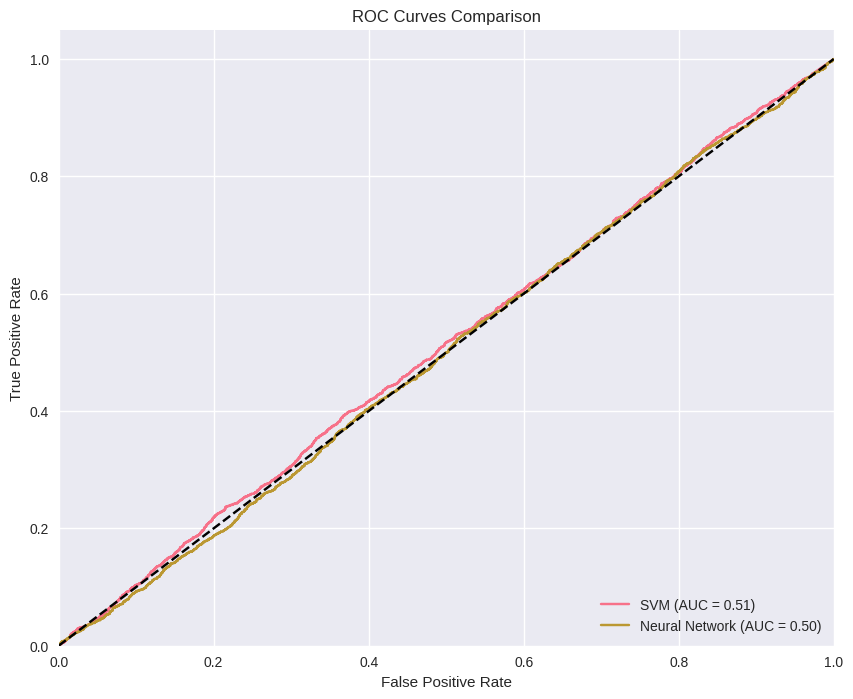

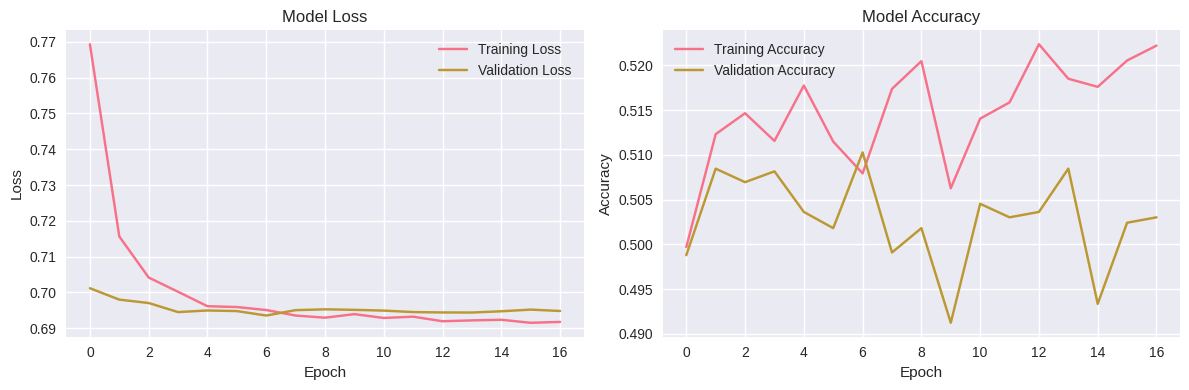

In [19]:

# Prepare the data similar to your previous code
data = pd.read_csv('lung_cancer_data.csv')

# Age Classification
bins = [30, 40, 50, 60, 70, 80]
labels = ['30s', '40s', '50s', '60s', '70s']
data['Age_Class'] = pd.cut(data['Age'], bins=bins, labels=labels, right=False)

# Convert categorical to numeric
le_age_class = LabelEncoder()
le_smoking = LabelEncoder()
le_tumor = LabelEncoder()
le_stage = LabelEncoder()

data['Age_Class'] = le_age_class.fit_transform(data['Age_Class'])
data['Smoking_History'] = le_smoking.fit_transform(data['Smoking_History'])
data['Tumor_Location'] = le_tumor.fit_transform(data['Tumor_Location'])
data['Stage'] = le_stage.fit_transform(data['Stage'])

# Create target variable
survival_threshold = 60
data['Survival'] = (data['Survival_Months'] >= survival_threshold).astype(int)

# Select features - adding more features for complex models
X = data[[
    'Smoking_History', 'Tumor_Location', 'Stage', 'Age_Class',
    'Tumor_Size_mm', 'Performance_Status', 'White_Blood_Cell_Count',
    'Hemoglobin_Level', 'Platelet_Count', 'LDH_Level'
]]
y = data['Survival']

# Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Support Vector Machine
print("\n=== Training SVM Model ===")
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Evaluate SVM
svm_pred = svm_model.predict(X_test_scaled)
svm_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

print("\nSVM Model Performance:")
print(classification_report(y_test, svm_pred))

# 2. Neural Network
print("\n=== Training Neural Network ===")

# Define the model
def create_nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train the neural network
nn_model = create_nn_model(X_train_scaled.shape[1])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = nn_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate Neural Network
nn_pred = (nn_model.predict(X_test_scaled) > 0.5).astype(int)
nn_prob = nn_model.predict(X_test_scaled).ravel()

print("\nNeural Network Performance:")
print(classification_report(y_test, nn_pred))

# Plot ROC curves for comparison
plt.figure(figsize=(10, 8))

# SVM ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_prob)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')

# Neural Network ROC
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_prob)
roc_auc_nn = auc(fpr_nn, tpr_nn)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Plot Neural Network training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()